In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark Logistic Regression example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [18]:
df = spark.read.format('com.databricks.spark.csv') \
            .options(header='true', inferschema='true') \
            .load("../data/bank.csv",header=True)

In [19]:
df.show(5, False)

+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|job        |marital|education|default|balance|housing|loan|contact |day|month|duration|campaign|pdays|previous|poutcome|y  |
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|30 |unemployed |married|primary  |no     |1787   |no     |no  |cellular|19 |oct  |79      |1       |-1   |0       |unknown |no |
|33 |services   |married|secondary|no     |4789   |yes    |yes |cellular|11 |may  |220     |1       |339  |4       |failure |no |
|35 |management |single |tertiary |no     |1350   |yes    |no  |cellular|16 |apr  |185     |1       |330  |1       |failure |no |
|30 |management |married|tertiary |no     |1476   |yes    |yes |unknown |3  |jun  |199     |4       |-1   |0       |unknown |no |
|59 |blue-collar|married|secondary|no     |0      |yes    |no  |unknown |5  |may  |226    

In [20]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [21]:
df.drop('day','month','poutcome').show(5, False)

+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
|age|job        |marital|education|default|balance|housing|loan|contact |duration|campaign|pdays|previous|y  |
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
|30 |unemployed |married|primary  |no     |1787   |no     |no  |cellular|79      |1       |-1   |0       |no |
|33 |services   |married|secondary|no     |4789   |yes    |yes |cellular|220     |1       |339  |4       |no |
|35 |management |single |tertiary |no     |1350   |yes    |no  |cellular|185     |1       |330  |1       |no |
|30 |management |married|tertiary |no     |1476   |yes    |yes |unknown |199     |4       |-1   |0       |no |
|59 |blue-collar|married|secondary|no     |0      |yes    |no  |unknown |226     |1       |-1   |0       |no |
+---+-----------+-------+---------+-------+-------+-------+----+--------+--------+--------+-----+--------+---+
o

In [25]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    #print(">>>>>>>>> fields are ",df.columns)
    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [26]:
df.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [27]:
catcols = ['job','marital','education','default','housing','loan','contact','poutcome']

num_cols = ['balance', 'duration','campaign','pdays','previous',]
labelCol = 'y'

data = get_dummy(df,catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[8,11,15,16,1...|   no|
|(29,[4,11,13,16,1...|   no|
|(29,[0,12,14,16,1...|   no|
|(29,[0,11,14,16,1...|   no|
|(29,[1,11,13,16,1...|   no|
+--------------------+-----+
only showing top 5 rows



In [30]:
#Dealing with categorical variables and labels

from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(15, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(29,[8,11,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
|(29,[0,12,14,16,1...|   no|         0.0|
|(29,[0,11,14,16,1...|   no|         0.0|
|(29,[1,11,13,16,1...|   no|         0.0|
|(29,[0,12,14,16,1...|   no|         0.0|
|(29,[6,11,14,16,1...|   no|         0.0|
|(29,[2,11,13,16,1...|   no|         0.0|
|(29,[7,11,14,16,1...|   no|         0.0|
|(29,[4,11,15,16,1...|   no|         0.0|
|(29,[4,11,13,16,1...|   no|         0.0|
|(29,[3,11,13,16,1...|   no|         0.0|
|(29,[2,11,14,16,1...|   no|         0.0|
|(29,[10,12,13,16,...|  yes|         1.0|
|(29,[1,11,13,16,1...|   no|         0.0|
+--------------------+-----+------------+
only showing top 15 rows



In [32]:
from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, False)

+---------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------+
|features                                                                                                 |label|indexedFeatures                                                                                          |
+---------------------------------------------------------------------------------------------------------+-----+---------------------------------------------------------------------------------------------------------+
|(29,[8,11,15,16,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1787.0,79.0,1.0,-1.0])                |no   |(29,[8,11,15,16,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1787.0,79.0,1.0,-1.0])                |
|(29,[4,11,13,16,17,19,22,24,25,26,27,28],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,4789.0,220.0,1.0,339.0,4.0])       |no   |(29,[4,

In [33]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+------------------------------------------------------------------------------------------------+-----+
|features                                                                                        |label|
+------------------------------------------------------------------------------------------------+-----+
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-588.0,81.0,4.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,238.0,808.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,466.0,164.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,725.0,266.0,1.0,-1.0])|no   |
|(29,[0,11,13,16,17,18,19,21,24,25,26,27],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,857.0,238.0,6.0,-1.0])|no   |
+------------------------------------------------------------------------------------------------+-----+
only showing top 5 rows

+-----------------------------

In [34]:
#Fit logistic regression model
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [38]:
# Convert indexed labels back to original labels.
from pyspark.ml.feature import IndexToString, StringIndexer
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

In [40]:
# Chain indexers and tree in a Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

In [41]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [42]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
|(29,[0,11,13,16,1...|   no|            no|
+--------------------+-----+--------------+
only showing top 5 rows



In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.101105


In [68]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print(trainingSummary)
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|0.004166666666666667|0.05466237942122187|
|0.008333333333333333|0.10932475884244373|
|0.011666666666666667|0.17041800643086816|
|0.014166666666666666| 0.2379421221864952|
+--------------------+-------------------+
only showing top 5 rows

areaUnderROC: 0.892948821007502


In [46]:
#visualization
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

In [54]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

In [58]:
y_true

,label
0,no
1,no
2,no
3,no
4,no
...,...
1805,no
1806,no
1807,yes
1808,yes


In [60]:
y_pred

,predictedLabel
0,no
1,no
2,no
3,no
4,no
...,...
1805,no
1806,yes
1807,no
1808,no


In [62]:
list(class_names)

['no', 'yes']

In [64]:
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[1563,   37],
       [ 146,   64]])

Confusion matrix, without normalization
[[1563   37]
 [ 146   64]]


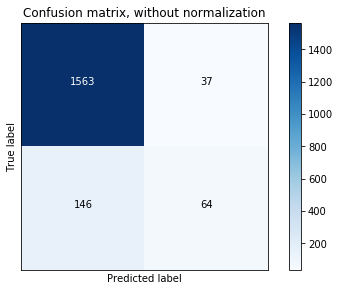

In [65]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(class_names),
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.976875  0.023125 ]
 [0.6952381 0.3047619]]


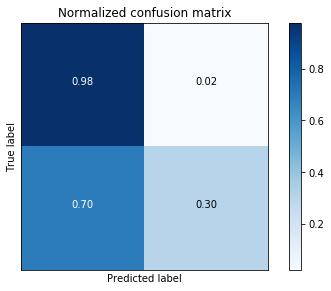

In [66]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(class_names), normalize=True,
                      title='Normalized confusion matrix')

plt.show()